# Imports


In [4]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

# Create Tiles

In [5]:
input_file_post = '../Datasets/Post_Event_San_Juan.tif'
input_file_pre = '../Datasets/Pre_Event_San_Juan.tif'
output_dir_post = "../Post_Event_Grids_In_TIFF"
output_dir_pre = "../Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512

In [ ]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [ ]:


generate_tiles(input_file_post, output_dir_post, grid_x, grid_y)
generate_tiles(input_file_pre, output_dir_pre, grid_x, grid_y)

# Convert tiles to jpg for labelling compatability

In [ ]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            print(os.path.join(output_dir, output_filename))
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [ ]:
output_dir_post_jpg = "../Post_Event_Grids_In_JPG"
output_dir_pre_jpg = "../Pre_Event_Grids_In_JPG"
input_dir_post = "../Post_Event_Grids_In_TIFF"
input_dir_pre = "../Pre_Event_Grids_In_TIFF"

convert_tiff_to_jpeg(input_dir_post, output_dir_post_jpg)
convert_tiff_to_jpeg(input_dir_pre, output_dir_pre_jpg)

In [ ]:
def rename_files(directory_path, prefix):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [ ]:
rename_files(output_dir_post_jpg, "Post_Event_")
rename_files(output_dir_pre_jpg, "Pre_Event_")

In [1]:
# Open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # Read the red band
        red = src.read(1)
        # Plot the red band
        plt.imshow(red, cmap='Reds')
        plt.title('Red Band')
        plt.show()


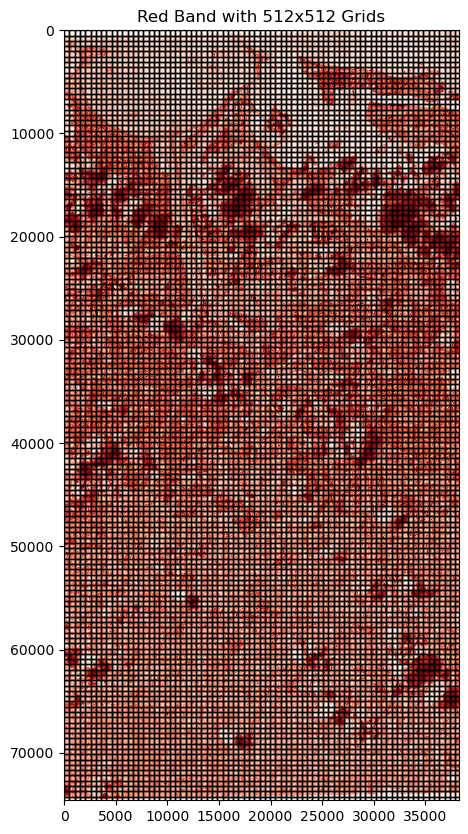

In [6]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_red_band_with_grids(image_path, grid_size=512):
    with rasterio.open(image_path) as src:
        # Read the red band (assuming it's the first band)
        red_band = src.read(1)
        
        # Image dimensions
        img_width, img_height = src.width, src.height
        
        # Setup the plot
        plt.figure(figsize=(10, 10))
        plt.imshow(red_band, cmap='Reds')
        plt.title('Red Band with 512x512 Grids')
        
        # Calculate and draw the grid lines
        for x in range(0, img_width, grid_size):
            for y in range(0, img_height, grid_size):
                plt.gca().add_patch(Rectangle((x, y), grid_size, grid_size, linewidth=1, edgecolor='black', facecolor='none'))
        
        # Adjust the plot view
        plt.xlim(0, img_width)
        plt.ylim(img_height, 0)  # Inverted to match the image's coordinate system
        plt.show()

# Replace 'image_path.tif' with the path to your GeoTIFF file
visualize_red_band_with_grids(input_file_post)
